# 1. Preparation of the dataset

Getting an extended dataset:

1. Get new data from https://www.bluebikes.com/system-data
2. Download the trip zip files for each month of 2019
3. Append them in one dataframe
4. Download current station data from website

All datasets used are provided.

## Libraries
Import the required libraries for later use.

In [119]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.cluster import KMeans

import time
from datetime import datetime, timedelta

# For Google Maps script
import json
import urllib
import requests

## Meta settings

In [2]:
# For Google Maps script
API_KEY = ''
GOOGLE_MAPS_DATA_FILE = "./datasets/google_api_data.json"

# Data provided
TRIP_DATA_PATH = './datasets/boston_2019.csv'
WEATHER_DATA_PATH = './datasets/weather_hourly_boston.csv'

# Station data from Blue Bikes website
STATION_DATA_PATH = './datasets/current_bluebikes_stations.csv'

# Load all csv for the different months in 2019 from Boston Bikes System Data
TRIP_DATA_WEBSITE_JANUARY = './datasets/csv/201901-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_FEBRUARY = './datasets/csv/201902-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_MARCH = './datasets/csv/201903-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_APRIL = './datasets/csv/201904-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_MAY = './datasets/csv/201905-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_JUNE = './datasets/csv/201906-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_JULY = './datasets/csv/201907-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_AUGUST = './datasets/csv/201908-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_SEPTEMBER = './datasets/csv/201909-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_OCTOBER = './datasets/csv/201910-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_NOVEMBER = './datasets/csv//201911-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_DECEMBER = './datasets/csv/201912-bluebikes-tripdata.csv'


# Assign datatypes for each dataframe
TRIP_DTYPES = {
    'start_time': 'datetime64',
    'end_time': 'datetime64',
    'start_station_id': 'int64',
    'end_station_id': 'int',
    'start_station_name': 'str',
    'end_station_name': 'str',
    'bike_id': 'int64',
    'user_type': 'str',
}

TRIP_WEBSITE_DTYPES = {
    'trip_duration': 'int64',
    'start_time': 'datetime64',
    'stop_time': 'datetime64',
    'start_station_id': 'int64',
    'start_station_name': 'str',
    'start_station_lat': 'float64',
    'start_station_lng': 'float64',
    'end_station_id': 'int',
    'end_station_name': 'str',
    'end_station_lat': 'float64',
    'end_station_lng': 'float64',
    'bike_id': 'int64',
    'user_type': 'str',
    'birth_year': 'int64',
    'gender': 'int64',
    'user_type_id': 'int64'
}

WEATHER_DTYPES = {
    'max_temp': 'float64',
    'min_temp': 'float64',
    'precip': 'int64'
}

STATION_DTYPES = {
    'station_id_string': 'str',
    'station_name': 'str',
    'station_lat': 'float64',
    'station_lng': 'float64',
    'district': 'str',
    'total_docks': 'int64',
    'deployment_year': 'int64',
    'station_id': 'int64',
    'public': 'str',
    'station_id': 'int64'
}


## Loading the data
Here we load the data into our notebook. 

We haves 3 types of data:

1. Trip_data: data on individual trips, each represented by one record, such as time or station info
2. Weather_data: data on temperature and rain for each hour
3. Station_data: data for each station (e.g. number of docks or deployment year)

In [3]:
# Read all  provided csv data for trips, weather and stations into dataframes
trip_data = pd.read_csv(TRIP_DATA_PATH)
weather_data = pd.read_csv(WEATHER_DATA_PATH)


We also use station data from the Boston Bikes website, as it contains more information about each station that may be useful later, such as the number of docks or the year of deployment.

In [4]:
# Read all the stations csv data from the Blue Bikes website
station_data = pd.read_csv(STATION_DATA_PATH)

We use the trip data from the Boston Bikes website because it contains slightly more information about each trip, such as gender or year of birth.

We load the trip data for each month and then concat them into one dataframe.

In [5]:
# Read all csv trip data for each month into dataframes
trip_data_website_january = pd.read_csv(TRIP_DATA_WEBSITE_JANUARY)
trip_data_website_february = pd.read_csv(TRIP_DATA_WEBSITE_FEBRUARY)
trip_data_website_march = pd.read_csv(TRIP_DATA_WEBSITE_MARCH)
trip_data_website_april = pd.read_csv(TRIP_DATA_WEBSITE_APRIL)
trip_data_website_may = pd.read_csv(TRIP_DATA_WEBSITE_MAY)
trip_data_website_june = pd.read_csv(TRIP_DATA_WEBSITE_JUNE)
trip_data_website_july = pd.read_csv(TRIP_DATA_WEBSITE_JULY)
trip_data_website_august = pd.read_csv(TRIP_DATA_WEBSITE_AUGUST)
trip_data_website_september = pd.read_csv(TRIP_DATA_WEBSITE_SEPTEMBER)
trip_data_website_october = pd.read_csv(TRIP_DATA_WEBSITE_OCTOBER)
trip_data_website_november = pd.read_csv(TRIP_DATA_WEBSITE_NOVEMBER)
trip_data_website_december = pd.read_csv(TRIP_DATA_WEBSITE_DECEMBER)

In [6]:
# Concat datasets for each month from website into one dataframe
trip_data_website = pd.concat([trip_data_website_january, trip_data_website_february, trip_data_website_march, trip_data_website_april, trip_data_website_june, trip_data_website_july, trip_data_website_august, trip_data_website_september, trip_data_website_october, trip_data_website_november, trip_data_website_december], ignore_index=True)

## Modify the data
### Trip data
First, we rename the columns of the trip data from the website to appropriate names. Since there are only two types of users (subscribers and customers), we binarize them into their own column. This will make clustering easier later. Finally, we assign the dtypes.

In [7]:
# Rename headers of website trip data
trip_data_website = trip_data_website.rename(columns={'tripduration':'trip_duration', 'starttime':'start_time', 'stoptime':'stop_time', 'start station id':'start_station_id', 'start station name':'start_station_name', 'start station latitude':'start_station_lat', 'start station longitude':'start_station_lng', 'end station id':'end_station_id', 'end station name':'end_station_name', 'end station latitude':'end_station_lat', 'end station longitude':'end_station_lng', 'bikeid':'bike_id', 'usertype':'user_type', 'birth year':'birth_year', 'gender':'gender'})

# Binarize the user type into own column (Subscriber = 1, Customer = 0) for both trip_data and trip_data_website
print(trip_data_website['user_type'].unique())
trip_data_website['user_type_id'] = trip_data_website.apply(lambda row: 1 if row.user_type == 'Subscriber' else 0, axis=1)

['Subscriber' 'Customer']


In [8]:
# Assign dtype to trip data website
trip_data_website = trip_data_website.astype(TRIP_WEBSITE_DTYPES)

### Weather data
The weather data provided ranges from 2015 to 2022. Here we only need the data for 2019, so we filter the data by year and sort it by date.

In [9]:
# Set date_time to pandas datetime
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

In [10]:
# Filter weather data for 2019
weather_data = weather_data[weather_data['date_time']<pd.to_datetime('2020-01-01 00:00:00')]
weather_data = weather_data[weather_data['date_time']>=pd.to_datetime('2019-01-01 00:00:00')]

# Sort weather data by date
weather_data = weather_data.sort_values(by='date_time')

For the weather data, we had to make some assumptions on how to interpret the data.

**Assumption 1**: For the duplicates, we assume that the weather changes throughout the hour. However, since we have no information on which part of the hour the weather changes, we take the first record of each duplicate.

**Assumption 2**: The time at which the ride begins is critical to the weather, since this is when the client decides to use the bike.

**Assumption 3**: Since some hours are missing in weather_data, we assume that the weather has not changed during this time. Therefore, we will fill these hours with the previous weather conditions. 

In [11]:
# Drop duplicates and keep first record
weather_data = weather_data.drop_duplicates(subset='date_time', keep='first')

# Generate all hours for 2019 and merge with weather data
hours_2019 = pd.DataFrame(pd.date_range(pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2019-12-31 23:00:00'), freq='H'), columns=['date_time'])
weather_all_hours = pd.merge(how='outer', left=weather_data, right=hours_2019, on='date_time').sort_values(by='date_time').reset_index(drop=True)

# Set date_time as index for dataframe
weather_all_hours = weather_all_hours.set_index('date_time')

# Fill missing values with forward fill and dtypes with backward fill
weather_all_hours = weather_all_hours.fillna(method='ffill')
weather_all_hours = weather_all_hours.fillna(method='bfill').astype(WEATHER_DTYPES)

Lastly, we will merge the weather data into the trip data, so each trip has the weather associated with it.

In [12]:
trip_data_website = pd.merge_asof(trip_data_website.sort_values('start_time'), weather_all_hours.sort_index(), left_on='start_time', right_index=True, direction='backward')

In [13]:
trip_data_website.head(1)

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_lat,start_station_lng,end_station_id,end_station_name,end_station_lat,end_station_lng,bike_id,user_type,birth_year,gender,user_type_id,max_temp,min_temp,precip
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1,1,5.6,5.6,1


### Station data
We can see that the header of station_data is not yet correct, the right values are in the first row. Therefore,  we need to set the first row as the header, delete the first record and reset the index. Then we will rename the columns to better fitting names.

In [14]:
station_data.head(1)

,Last Updated,12/5/2022,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year


In [15]:
# Set header to first row values
station_data.columns = station_data.iloc[0]

# Remove first row by slicing
station_data = station_data[1:]


In [16]:
# Reset index
station_data.reset_index(drop=True, inplace=True)

In [17]:
# Rename headers
station_data = station_data.rename(columns={'Number': 'station_id_string', 'Name': 'station_name', 'District': 'district', 'Total docks': 'total_docks', 'Deployment Year': 'deployment_year', 'Public': 'public', 'Latitude':'station_lat', 'Longitude':'station_lng'})

In [18]:
station_data.head(1)

,station_id_string,station_name,station_lat,station_lng,district,public,total_docks,deployment_year
0,K32015,1200 Beacon St,42.34414899,-71.11467361,Brookline,Yes,15,2021


Now we check the station data for missing values.

In [19]:
# Check for NaN in station_data
station_data[station_data.isnull().any(axis=1)]

,station_id_string,station_name,station_lat,station_lng,district,public,total_docks,deployment_year
7,S32049,515 Somerville Ave (Temp. Winter Location),42.38322727,-71.10606909,NaN,Yes,19,NaN
65,D32056,Boylston St at Charles St,42.35257609,-71.06764405,Boston,Yes,31,NaN
83,S32044,Broadway Opposite Norwood Ave (Temp Winter St...,42.396764,-71.102376,Somerville,Yes,15,NaN
236,M32083,John Ahern Field at Kennedy-Longfellow School,42.36903567,-71.0863096,NaN,Yes,19,NaN
262,G32003,Malden High School,42.42653766,-71.06393695,NaN,Yes,11,2022
302,T32015,North St at Liberty Hill Ave,42.52989965,-70.90614259,NaN,Yes,11,2022
401,S32042,Trum Field @ Cedar St (Temp Winter Station),42.398444,-71.107833,Somerville,Yes,19,NaN


In [20]:
# Check for NaN in each column
print('There are ' + str(station_data.isnull().sum().sum()) + ' missing values in total.')
print('There are ' + str(station_data['station_id_string'].isnull().sum()) + ' missing values in station id string.')
print('There are ' + str(station_data['station_name'].isnull().sum()) + ' missing values in station name.')
print('There are ' + str(station_data['station_lat'].isnull().sum()) + ' missing values in station lat.')
print('There are ' + str(station_data['station_lng'].isnull().sum()) + ' missing values in station lng.')
print('There are ' + str(station_data['district'].isnull().sum()) + ' missing values in district.')
print('There are ' + str(station_data['public'].isnull().sum()) + ' missing values in public.')
print('There are ' + str(station_data['total_docks'].isnull().sum()) + ' missing values in total docks.')
print('There are ' + str(station_data['deployment_year'].isnull().sum()) + ' missing values in deployment year.')

There are 9 missing values in total.
There are 0 missing values in station id string.
There are 0 missing values in station name.
There are 0 missing values in station lat.
There are 0 missing values in station lng.
There are 4 missing values in district.
There are 0 missing values in public.
There are 0 missing values in total docks.
There are 5 missing values in deployment year.


We can see that there are 9 missing values in total. 

Four of them in the district column. Therefore, we check where they appear and fill them with the correct value after a manual Google Maps search.



In [21]:
# Fill missing values with the correct district
station_data.loc[7].district='Somerville'
station_data.loc[236].district='Cambridge'
station_data.loc[262].district='Malden'
station_data.loc[302].district='Salem'

In [22]:
# Check district NaN
print('There are ' + str(station_data['district'].isnull().sum()) + ' missing values in district.')

There are 0 missing values in district.


For the deployment year, we can see that 3 of the 5 stations have a "Temp Winter Station" in their name. We assume that they are only used in winter each year and therefore have the current year as their year of deployment - in this case 2022.

In [23]:
# Fill missing deployment years
station_data.loc[7].deployment_year=2022
station_data.loc[83].deployment_year=2022
station_data.loc[401].deployment_year=2022

In [24]:
# Check deployment NaN
print('There are ' + str(station_data['deployment_year'].isnull().sum()) + ' missing values in deployment year.')

There are 2 missing values in deployment year.


For the missing 2 values, we have no indication of when the year of deployment was. After searching the trip data for 'Boylston St at Charles St' and 'John Ahern Field at Kennedy-Longfellow School', we can see that there are no trips associated with either station.

In [25]:
# For both stations there are no results for the starting and ending station
print(trip_data_website[trip_data_website['start_station_name'].str.contains('Boylston St at Charles St')])
print(trip_data_website[trip_data_website['end_station_name'].str.contains('Boylston St at Charles St')])
print(trip_data_website[trip_data_website['start_station_name'].str.contains('John Ahern Field at Kennedy-Longfellow School')])
print(trip_data_website[trip_data_website['end_station_name'].str.contains('John Ahern Field at Kennedy-Longfellow School')])

Empty DataFrame
Columns: [trip_duration, start_time, stop_time, start_station_id, start_station_name, start_station_lat, start_station_lng, end_station_id, end_station_name, end_station_lat, end_station_lng, bike_id, user_type, birth_year, gender, user_type_id, max_temp, min_temp, precip]
Index: []
Empty DataFrame
Columns: [trip_duration, start_time, stop_time, start_station_id, start_station_name, start_station_lat, start_station_lng, end_station_id, end_station_name, end_station_lat, end_station_lng, bike_id, user_type, birth_year, gender, user_type_id, max_temp, min_temp, precip]
Index: []
Empty DataFrame
Columns: [trip_duration, start_time, stop_time, start_station_id, start_station_name, start_station_lat, start_station_lng, end_station_id, end_station_name, end_station_lat, end_station_lng, bike_id, user_type, birth_year, gender, user_type_id, max_temp, min_temp, precip]
Index: []
Empty DataFrame
Columns: [trip_duration, start_time, stop_time, start_station_id, start_station_name

Therefore, we delete both stations from station_data and reset the index.

In [26]:
# Drop Boylston St at Charles St (index=65) from station_data
station_data = station_data.drop([65])

# Drop John Ahern Field at Kennedy-Longfellow School (index=236) from station_data
station_data = station_data.drop([236])

# Reset index
station_data.reset_index(drop=True, inplace=True)

As shown below, there are now no missing values.

In [27]:
# Check for NaN
station_data[station_data.isnull().any(axis=1)]

,station_id_string,station_name,station_lat,station_lng,district,public,total_docks,deployment_year


We can see that there are more stations in station_data than stations are appearing in trip_data. Therefore, we extract the stations from trip_data and merge them with the information available in the station data.

In [28]:
# Check amount of stations in station_data and trip_data
print('There are ' + str(len(station_data['station_name'].unique())) + ' stations in the station data.')
print('There are ' + str(len(trip_data_website['start_station_id'].unique())) + ' start stations in trip data.')
print('There are ' + str(len(trip_data_website['end_station_id'].unique())) + ' end stations in trip data.')

There are 446 stations in the station data.
There are 338 start stations in trip data.
There are 339 end stations in trip data.


In [29]:
# Get all unique start and end stations
start_stations = trip_data_website.drop_duplicates(subset="start_station_id", keep="first")[["start_station_id","start_station_name", "start_station_lat", "start_station_lng"]].sort_values(by="start_station_id").reset_index(drop=True)
end_stations = trip_data_website.drop_duplicates(subset="end_station_id", keep="first")[["end_station_id","end_station_name", "end_station_lat", "end_station_lng"]].sort_values(by="end_station_id").reset_index(drop=True)

# Merge all unique start and end stations into one dataframe
all_stations = start_stations.merge(end_stations, left_on='start_station_id', right_on="end_station_id", how='outer', suffixes=['', '_'], indicator=True)

In [30]:
# Check for NaN in all_stations
all_stations[all_stations.isnull().any(axis=1)]

,start_station_id,start_station_name,start_station_lat,start_station_lng,end_station_id,end_station_name,end_station_lat,end_station_lng,_merge
202,229.0,8D QC Station 01,42.345033,-71.096649,NaN,NaN,NaN,NaN,left_only
278,383.0,MTL-ECO5.1-01,0.000000,0.000000,NaN,NaN,NaN,NaN,left_only
338,NaN,NaN,NaN,NaN,164.0,Warehouse Lab PBSC,42.386455,-71.07542,right_only
339,NaN,NaN,NaN,NaN,230.0,8D QC Station 02,0.000000,0.00000,right_only
340,NaN,NaN,NaN,NaN,382.0,MTL-ECO4-01,0.000000,0.00000,right_only


We can see that there are 5 stations with missing values - 2 start stations and 3 end stations. 

This means that the first two stations **only** appear as start stations and **never** appear as end stations, and the last 3 stations **only** appear as end stations and **never** appear as start stations, which explains the results above.

The samples where no values for latitude and longitude are given are problematic, here ***MTL-ECO5.1-01*** (start), ***8D QC Station 02*** (end) and ***MTL-ECO4-01*** (end).

We will now check in which of the trips the stations occur.

In [31]:
# # Check all trips for starting station: MTL-ECO5.1-01
# for index, row in trip_data_website.iterrows():
#     if 'MTL-ECO5.1-01' in row['start_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

In [32]:
# # Check all trips for ending station: 8D QC Station 02
# for index, row in trip_data_website.iterrows():
#     if '8D QC Station 02' in row['end_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

In [33]:
# # Check all trips for ending station: MTL-ECO4-01
# for index, row in trip_data_website.iterrows():
#     if 'MTL-ECO4-01' in row['end_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

For ***MTL-ECO5.1-01*** (start) and ***MTL-ECO4-01*** (end) there is one trip with the ID ***994366***. 
For ***8D QC Station 02*** (end) there is a trip from ***8D QC Station 01*** (start) with the ID ***50153***.

We can also check with the stations dataset which of the stations above are appearing. We can neither find ***8D QC Station 02*** nor ***MTL-ECO4-01***. We can find ***MTL-ECO5.1-01*** and ***8D QC Station 01*** as listed stations.

For ***8D QC Station 01*** we have latitude and longitude values, but if there is only one occurrence in trip_data, it is not so important, so we check it as well.

In [34]:
# # Check all trips for starting station: 8D QC Station 01
# for index, row in trip_data_website.iterrows():
#     if '8D QC Station 01' in row['start_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

Since there is only one trip associated with each of the stations (***8D QC Station 01***, ***8D QC Station 02***, ***MTL-ECO5.1-01***, and ***MTL-ECO4-01***), they do not seem important to the scope of the task. Therefore, the trips are deleted from the trip data.



In [35]:
# Drop trips by id 
trip_data_website = trip_data_website.drop([50153])
trip_data_website = trip_data_website.drop([994366])

# Reset index
trip_data_website.reset_index(drop=True, inplace=True)


Next, we remove the stations listed above from the all_stations dataframe.

In [36]:
# Drop stations by id (8D QC Station 01 id=202, MTL-ECO5.1-01 id=278, 8D QC Station 02 id=339, MTL-ECO4-01 id=340)
all_stations = all_stations.drop([202])
all_stations = all_stations.drop([278])
all_stations = all_stations.drop([339])
all_stations = all_stations.drop([340])

# Reset index
all_stations.reset_index(drop=True, inplace=True)

In [37]:
# Check for NaN
all_stations[all_stations.isnull().any(axis=1)]

,start_station_id,start_station_name,start_station_lat,start_station_lng,end_station_id,end_station_name,end_station_lat,end_station_lng,_merge
336,NaN,NaN,NaN,NaN,164.0,Warehouse Lab PBSC,42.386455,-71.07542,right_only


As there is one more end station than start station, we will use the end stations as the basis for our station data. 

We can omit the columns *start_station_id*, *start_station_name*, *start_station_lat* and *start_station_lng* because they provide the same information as the end station values. Then we rename the columns to appropriate names.

In [38]:
#  We will drop the columns start_station_id, start_station_name, start_station_lat, start_station_lng as they are not needed
all_stations = all_stations.drop(['start_station_id', 'start_station_name', 'start_station_lat', 'start_station_lng', '_merge' ], axis=1)

In [39]:
# Rename columns
all_stations = all_stations.rename(columns={'end_station_id': 'station_id', 'end_station_name': 'station_name', 'end_station_lat': 'station_lat', 'end_station_lng': 'station_lng'})

In [40]:
all_stations.head(1)

,station_id,station_name,station_lat,station_lng
0,1.0,18 Dorrance Warehouse,42.387151,-71.075978


Next, all the stations that show up in the trip data are merged into a new dataframe with the additional information we have about each station.

In [41]:
# Create new dataframe from station_data and all_stations
total_station_data = station_data.drop(['station_lat', 'station_lng'], axis=1).merge(all_stations, right_on='station_name', left_on='station_name', how='right')

Now we check again for missing values.

In [42]:
# Check for NaN
total_station_data[total_station_data.isnull().any(axis=1)]

,station_id_string,station_name,district,public,total_docks,deployment_year,station_id,station_lat,station_lng
0,NaN,18 Dorrance Warehouse,NaN,NaN,NaN,NaN,1.0,42.387151,-71.075978
18,NaN,Prudential Center - Belvedere St,NaN,NaN,NaN,NaN,21.0,42.346520,-71.080658
35,NaN,Boylston St at Arlington St,NaN,NaN,NaN,NaN,42.0,42.352567,-71.067705
40,NaN,Post Office Square - Pearl St at Milk St,NaN,NaN,NaN,NaN,48.0,42.356755,-71.055407
48,NaN,Dudley Square - Dudley St at Warren St,NaN,NaN,NaN,NaN,56.0,42.328540,-71.084165
49,NaN,Columbus Ave at Massachusetts Ave,NaN,NaN,NaN,NaN,57.0,42.340543,-71.081388
57,NaN,Allston Green District - Griggs St at Commonwe...,NaN,NaN,NaN,NaN,66.0,42.349225,-71.132753
70,NaN,Beacon St at Washington / Kirkland,NaN,NaN,NaN,NaN,79.0,42.378420,-71.105668
76,NaN,Brookline Village - Pearl Street at MBTA,NaN,NaN,NaN,NaN,86.0,42.332799,-71.116205
78,NaN,Inman Square at Vellucci Plaza / Hampshire St,NaN,NaN,NaN,NaN,88.0,42.374035,-71.101427


There are quite a few samples in the trip data from 2019 that are not included in the current list of stations. 

As we do not have more information about the stations even after checking the other station files from Boston Bikes website, we decide to fill the NaN data with proper values.

1) *total_docks* and *deployment_year* will be filled with -1, implying there is no info.
2) *station_id_string* will be filled with the predefined format (X00000).
3) For *public*, we noticed that the only values used are 'Yes' and 'nan'. Therefore, we assume that all known stations are public.
4) For *district*, we will perform a Google Maps search to fill the district info (see below).

In [43]:
# Fill station data station id string with format X000000
total_station_data['station_id_string'] = total_station_data['station_id_string'].fillna('X00000')

# Fill station data public with 'Yes'
total_station_data['public'] = total_station_data['public'].fillna('Yes')

# Fill station data deployment year and total docks with -1
total_station_data['deployment_year'] = total_station_data['deployment_year'].fillna(-1)
total_station_data['total_docks'] = total_station_data['total_docks'].fillna(-1)


In [44]:
# Check for missing values in total_station_data
total_station_data[total_station_data.isnull().any(axis=1)].head(1)

,station_id_string,station_name,district,public,total_docks,deployment_year,station_id,station_lat,station_lng
0,X00000,18 Dorrance Warehouse,NaN,Yes,-1,-1,1.0,42.387151,-71.075978


In [45]:
# Assign dtype to total_station_data station_id
total_station_data.station_id = total_station_data.station_id.astype('int64')

In [46]:
# # Script to lookup the station names in Google Maps through their Find Place API
# rows_with_nan = total_station_data[total_station_data.isnull().any(axis=1)]

# def get_google_place_data(stations):
#     station_info = {}
#     url_endpoint = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"

#     for index, record in stations.iterrows():
#         url_query_params = f"?input={urllib.parse.quote_plus(record.station_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}&point:42.387151,-71.075978"
#         url = url_endpoint + url_query_params
#         payload={}
#         headers = {}
#         response = requests.request("GET", url, headers=headers, data=payload)
#         response = json.loads(response.text)
#         if not response["candidates"]:
#             print(f"--------{index}___{record.station_name}")
#             url_query_params = f"?input={urllib.parse.quote_plus(record.station_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}"
#             url = url_endpoint + url_query_params
#             print(url)
#             response = requests.request("GET", url, headers=headers, data=payload)
#             response = json.loads(response.text)
#         station_info[record.station_id] = response
#     return station_info

# google_api_data = get_google_place_data(rows_with_nan)

# # Saving the data in a JSON-file

# with open(GOOGLE_MAPS_DATA_FILE, 'w') as fp:
#     json.dump(google_api_data, fp)



After checking the json file created via the Google Maps API and the station data (see below), we find that in most cases it works as expected. For some stations, the values are not correct, e.g. locations were found in the UK or other parts of the US. Therefore, we will override these values with a manual Google Maps search with latitude and longitude values.

In [47]:
# We will fill in some districts manually through their lat and long values as they were not found correct via the Google Maps Find Place API
total_station_data.at[18, 'district']='Boston' # Prudential Center - Belvedere St
total_station_data.at[44, 'district']='Boston' # Congress St at North St
total_station_data.at[57, 'district']='Boston' # Allston Green District - Griggs St at Commonwealth Ave
total_station_data.at[70, 'district']='Somerville' # Beacon St at Washington / Kirkland
total_station_data.at[76, 'district']='Brookline' # Brookline Village - Pearl Street at MBTA
total_station_data.at[78, 'district']='Cambridge' # Inman Square at Vellucci Plaza / Hampshire St
total_station_data.at[82, 'district']='Boston' # University of Massachusetts Boston - Integrated Sciences Complex 100
total_station_data.at[91, 'district']='Somerville' # Ball Sq
total_station_data.at[100, 'district']='Cambridge' # Harvard University Gund Hall at Quincy St / Ki...
total_station_data.at[160, 'district']='Cambridge' # Sidney Research Campus/ Erie Street at Waverly
total_station_data.at[171, 'district']='East Cambridge' # Child St at North St
total_station_data.at[174, 'district']='Boston' # Upham's Corner T Stop - Magnolia St at Dudley St
total_station_data.at[209, 'district']='Boston' # Washington St at Bradlee St
total_station_data.at[224, 'district']='Newton' # Washington St at Myrtle St
total_station_data.at[225, 'district']='Somerville' # 30 Dane St.
total_station_data.at[261, 'district']='Boston' #  Broadway T Stop W
total_station_data.at[280, 'district']='Everett' # Main Street at Carter Street
total_station_data.at[288, 'district']='Everett' # Wasgatt Playground
total_station_data.at[328, 'district']='Cambridge' # Mobile Temporary Station
total_station_data.at[335, 'district']='Boston' # Warehouse Lab PBSC

Now we fill the districts found via the Google Maps API for each station.

In [48]:
# Get all stations with missing district and load JSON data from above
rows_with_nan = total_station_data[total_station_data.isnull().any(axis=1)]
data = json.load(open(GOOGLE_MAPS_DATA_FILE))

# For each record with a missing district we lookup the corresponding station id in the JSON file
for index, row in rows_with_nan.iterrows():
    station_id = row.station_id
    json_station_data = data[str(station_id)]["candidates"][0]
    original_station = total_station_data[total_station_data.station_id == station_id]
    
    # We  split the data to find the district, as the addresses found are connected with a comma. 
    # Sometimes no direct address is provided, so we need to check the length of the split.
    # If the length is 4, an address is provided, if its 3, then no address is provided
    formatted_address = json_station_data["formatted_address"].split(",")
    district = formatted_address[0].strip() if len(formatted_address) == 3 else formatted_address[1].strip()

    # We will fill out the original dataframe with the JSON data
    total_station_data.at[total_station_data.station_id == station_id, "district"] = district

InvalidIndexError: 0       True
1      False
2      False
3      False
4      False
       ...  
332    False
333    False
334    False
335    False
336    False
Name: station_id, Length: 337, dtype: bool

In [49]:
# Check for missing values in total_station_data
total_station_data[total_station_data.isnull().any(axis=1)]

,station_id_string,station_name,district,public,total_docks,deployment_year,station_id,station_lat,station_lng
0,X00000,18 Dorrance Warehouse,NaN,Yes,-1,-1,1,42.387151,-71.075978
35,X00000,Boylston St at Arlington St,NaN,Yes,-1,-1,42,42.352567,-71.067705
40,X00000,Post Office Square - Pearl St at Milk St,NaN,Yes,-1,-1,48,42.356755,-71.055407
48,X00000,Dudley Square - Dudley St at Warren St,NaN,Yes,-1,-1,56,42.328540,-71.084165
49,X00000,Columbus Ave at Massachusetts Ave,NaN,Yes,-1,-1,57,42.340543,-71.081388
99,X00000,TD Garden - West End Park,NaN,Yes,-1,-1,109,42.365908,-71.064467
118,X00000,Upham's Corner,NaN,Yes,-1,-1,130,42.317275,-71.065370
138,X00000,Somerville Hospital,NaN,Yes,-1,-1,156,42.390888,-71.109626
143,X00000,Franklin Park - Seaver St at Humbolt Ave,NaN,Yes,-1,-1,162,42.309796,-71.092225
183,X00000,Chelsea St at Saratoga St,NaN,Yes,-1,-1,209,42.379772,-71.027448


In [50]:
# Assign dtypes to stations
total_station_data = total_station_data.astype(STATION_DTYPES)

Now we count the trips for each station, so we can visualize it later on.

In [51]:
# Count amount of trips for starting and ending stations
start_station_count = pd.DataFrame(trip_data_website.start_station_id.value_counts())
end_station_count = pd.DataFrame(trip_data_website.end_station_id.value_counts())

# Rename columns to fitting names
start_station_count = start_station_count.rename(columns={'start_station_id':'start_station_count'})
end_station_count = end_station_count.rename(columns={'end_station_id':'end_station_count'})

# Merge station counts into station data
total_station_data = total_station_data.merge(start_station_count, right_index=True, left_on='station_id')
total_station_data = total_station_data.merge(end_station_count, right_index=True, left_on='station_id')

# Calculate total amount of trips for each station
total_station_data['total_station_count'] = total_station_data['start_station_count'] + total_station_data['end_station_count']

In [52]:
total_station_data.head(1)

,station_id_string,station_name,district,public,total_docks,deployment_year,station_id,station_lat,station_lng,start_station_count,end_station_count,total_station_count
0,X00000,18 Dorrance Warehouse,nan,Yes,-1,-1,1,42.387151,-71.075978,459,1112,1571


The following data sets are the important ones for later use:

- **total_station_data**: all data provided on each station
- **trip_data_website**: all trips with weather data and station data

In [53]:
trip_data_website.head(1)

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_lat,start_station_lng,end_station_id,end_station_name,end_station_lat,end_station_lng,bike_id,user_type,birth_year,gender,user_type_id,max_temp,min_temp,precip
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1,1,5.6,5.6,1


# 2. Plotting the data

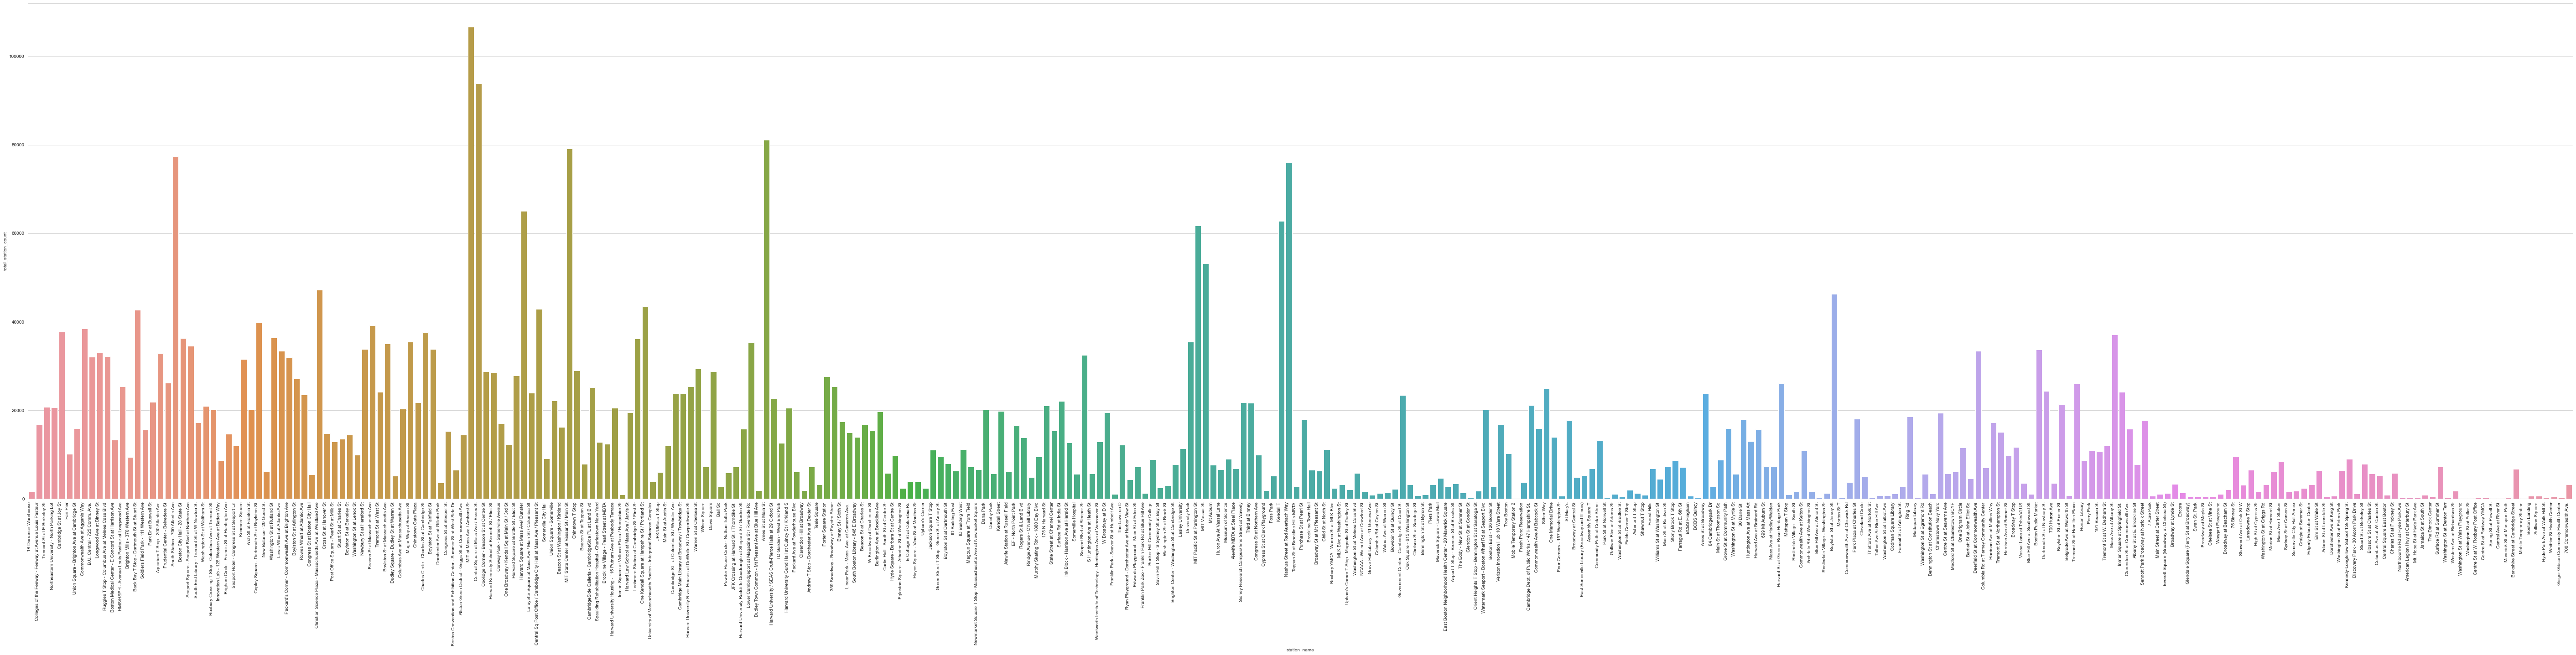

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

#Show overview of all stations and total bike counts
fig, ax = plt.subplots(figsize=(100, 20))
sns.barplot(data=total_station_data, x="station_name", y="total_station_count", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

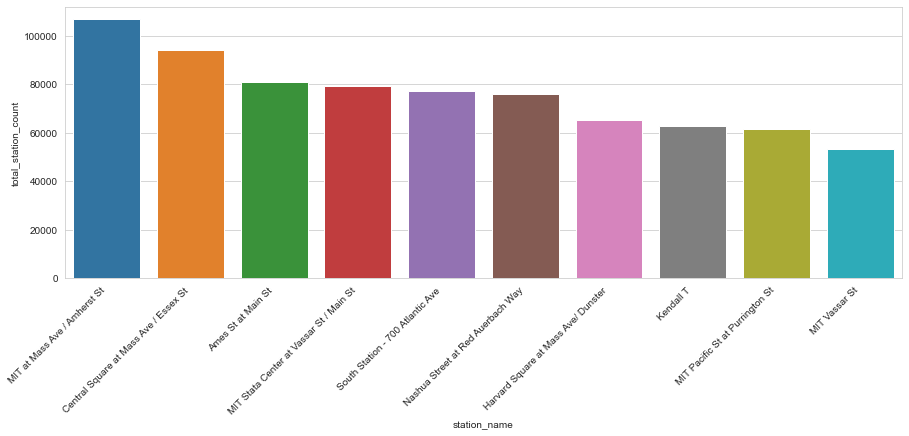

In [55]:
#Show top 10 stations
df_top10_total = pd.DataFrame(total_station_data.nlargest(n=10, columns=['total_station_count']))
#print(df_top10_total)

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_top10_total, x="station_name", y="total_station_count", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [56]:
from bokeh.io import output_notebook, show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions, ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Blues8, Oranges8

#Showing the Boston stations on Google Maps
#Adding map_radius for better map visualisation
total_station_data["map_count_radius"] = total_station_data["total_station_count"] / 2000
total_station_data["map_count_radius"] = total_station_data.apply(lambda row: 7 if row["map_count_radius"] < 7 else row["map_count_radius"], axis=1)

#Adding colors, in which the stations will be represented on the map
lowest_total_count = list(total_station_data.nsmallest(6, "total_station_count").station_id_string)
highest_total_count = list(total_station_data.nlargest(5, "total_station_count").station_id_string)
def set_map_color(row):
    if row["station_id_string"] in lowest_total_count:
        return "blue"
    elif row["station_id_string"] in highest_total_count:
        return "green"
    else:
        return "red"

total_station_data["map_count_color"] = total_station_data.apply(lambda row: set_map_color(row), axis=1)

#Boston location
gmap_options = GMapOptions(lat= 42.3580089, lng=-71.1004676, map_type='roadmap', zoom=12)
map_source = ColumnDataSource(total_station_data)

output_notebook()
bokeh_width, bokeh_height = 800,600

#Show station details
hover_count = HoverTool(tooltips = [('Station', '@station_name'), ('Total Count', '@total_station_count')])

p_count = gmap(API_KEY, gmap_options, title='Boston Bike Station Distribution', 
               width=bokeh_width, height=bokeh_height, 
               tools=[hover_count, 'reset', 'wheel_zoom', 'pan']
              )
p_count.circle('station_lng', 'station_lat', size='map_count_radius', alpha=0.4, 
                  color='map_count_color', source=map_source)

show(p_count)

Loading BokehJS ...

## Clustering

### Customer types

#### Simple clustering 
First we will try to differentiate the user groups by their attribute *user_type*. For that we will use proportinal sampling to increase execution time and StandardScaler to standardize all features except the user type.

In [90]:
# Calculate age of user for each trip
trip_data_website['age'] = 2019 - trip_data_website['birth_year']

# Create df for clustering with relevant columns only
clustering_data = trip_data_website[['trip_duration', 'user_type', 'gender', 'age', 'precip']]

In [101]:
# WICHTIG?
# Sampling(in order to don't take so much time) and check if Customer types can be simply seperated into Subscriber and Customer given by original dataset
# gbr = clustering_data.groupby("user_type") 
# gbr.groups

In [113]:
# Proportional sampling to create equal number of samples and reduce size
typicalFracDict = {
    'Subscriber': 0.01,
    'Customer': 0.01
}

# Function for sampling the clustering data
def sampling(group, typicalFracDict):
    name = group.name
    frac = typicalFracDict[name]
    return group.sample(frac=frac)

# Create clustering sample
clustering_sample = clustering_data.groupby('user_type', group_keys=False).apply(sampling, typicalFracDict)

# Import and initialize StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create x_sample without user_type and y_sample  with only the user_type
x_sample = clustering_sample.drop('user_type', axis=1)
y_sample = clustering_sample[['user_type']]

# Compute the mean and std for x_sample to be used for later scaling
scaler.fit(x_sample)

# Perform standardization by centering and scaling x_sample
x_scaled_sample = scaler.transform(x_sample)

# Create df for scaled sample
x_scaled_sample_df = pd.DataFrame(x_scaled_sample, columns=x_sample.columns, index=x_sample.index)

# Create trip_scaled with scaled features and add user type
trip_scaled = x_scaled_sample_df
trip_scaled['user_type'] = y_sample


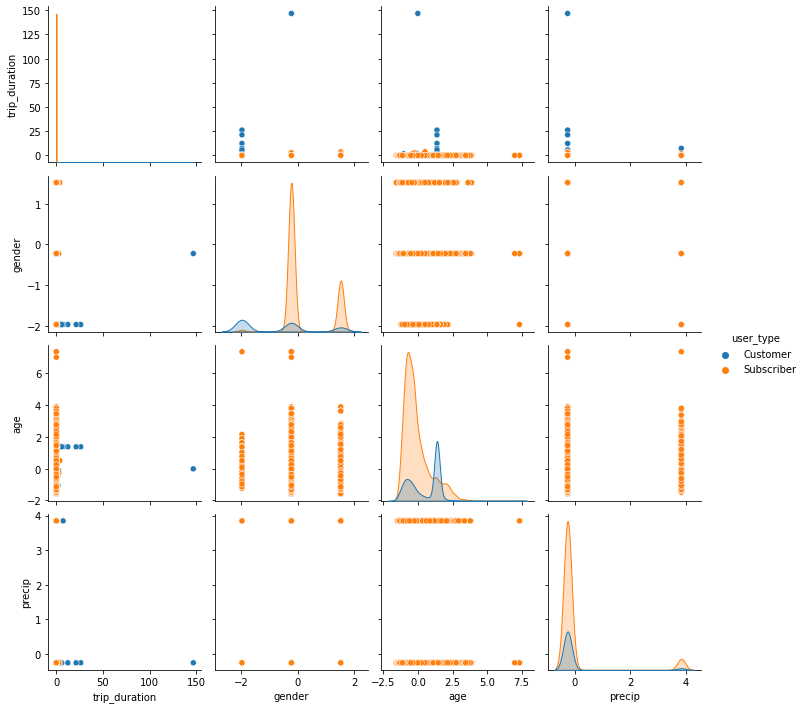

In [114]:
# Plot trip data with Seaborn
pairplot = sns.pairplot(data=trip_scaled, hue='user_type')

We can see that there is no clear distinction between the two user types. Therefore, we will use k-means for the next clustering analysis.

#### K-Means

In [ ]:
# Calculate age of user for each trip
trip_data_website['age'] = 2019 - trip_data_website['birth_year']

# Create df for clustering with relevant columns only
clustering_data = trip_data_website[['trip_duration', 'user_type', 'gender', 'age', 'precip']]

In [191]:
X_clustering_kmeans = trip_data_website[['trip_duration', 'gender', 'age', 'precip', 'user_type_id']].drop('user_type_id', axis=1)
y_clustering_kmeans = trip_data_website['user_type_id']

scaler.fit(X_clustering_kmeans)

X_clustering_kmeans_scaled = scaler.transform(X_clustering_kmeans)

X_clustering_kmeans_scaled_df = pd.DataFrame(X_clustering_kmeans_scaled, columns=X_clustering_kmeans, index=X_clustering_kmeans.index)

ValueError: Index data must be 1-dimensional

In [187]:
X_clustering_kmeans.reset_index()

,index,trip_duration,gender,age,precip
0,0,371,1,32,1
1,1,264,1,29,1
2,2,458,1,42,1
3,3,364,1,26,1
4,4,681,2,40,1
...,...,...,...,...,...
2299680,2299680,1562,1,24,0
2299681,2299681,2250,1,24,0
2299682,2299682,397,1,25,0
2299683,2299683,360,1,54,0


In [185]:
X_clustering_kmeans = trip_data_website[['trip_duration', 'gender', 'age', 'precip']]
y_clustering_kmeans = trip_data_website['user_type_id']

scaler.fit(X_clustering_kmeans)

X_clustering_kmeans_scaled = scaler.transform(X_clustering_kmeans)

X_clustering_kmeans_scaled_df = pd.DataFrame(X_clustering_kmeans_scaled, columns=X_clustering_kmeans, index=X_clustering_kmeans.index)

ValueError: Index data must be 1-dimensional

In [ ]:
# Proportional sampling to create equal number of samples and reduce size
typicalFracDict = {
    'Subscriber': 0.01,
    'Customer': 0.01
}

# Function for sampling the clustering data
def sampling(group, typicalFracDict):
    name = group.name
    frac = typicalFracDict[name]
    return group.sample(frac=frac)

# Create clustering sample
clustering_sample = clustering_data.groupby('user_type', group_keys=False).apply(sampling, typicalFracDict)

# Import and initialize StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create x_sample without user_type and y_sample  with only the user_type
x_sample = clustering_sample.drop('user_type', axis=1)
y_sample = clustering_sample[['user_type']]

# Compute the mean and std for x_sample to be used for later scaling
scaler.fit(x_sample)

# Perform standardization by centering and scaling x_sample
x_scaled_sample = scaler.transform(x_sample)

# Create df for scaled sample
x_scaled_sample_df = pd.DataFrame(x_scaled_sample, columns=x_sample.columns, index=x_sample.index)

# Create trip_scaled with scaled features and add user type
trip_scaled = x_scaled_sample_df
trip_scaled['user_type'] = y_sample

In [ ]:
scaler.fit(X_clustering_kmeans)
print(X_clustering_kmeans)
X_clustering_kmeans_scaled = scaler.transform(X_clustering_kmeans)
print(X_clustering_kmeans_scaled)
X_clustering_kmeans_scaled_df = pd.DataFrame(X_clustering_kmeans_scaled, columns=X_clustering_kmeans, index=X_clustering_kmeans.index)
X_clustering_kmeans_scaled_df.head()

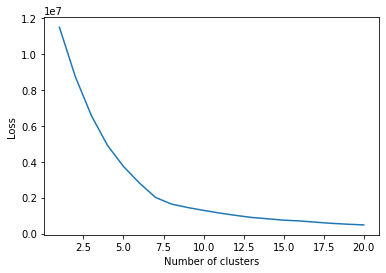

In [120]:
# Initialize values
k_max = 20
clusters = []
losses = []

# Create df for kmeans
X = trip_data_website[['trip_duration', 'user_type_id', 'gender', 'age', 'precip']]

# Drop wrong values
# ...

# Perform standardization of features by centering and scaling
scaler.fit(X)
X_scaled = scaler.transform(X)

# Find best k
for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

# Visualization
plt.plot(clusters, losses)
plt.ylabel('Loss')
plt.xlabel('Number of clusters')
plt.show()

(3.0, 9.0)

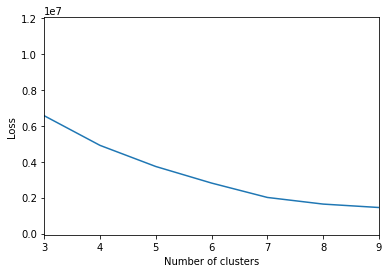

In [124]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([3,9])

We can see that **4** to **7** seems to be the proper region to perform kmeans. We try to reduce the number of groups with still a good result, so we pick 4 as our number of clusters.

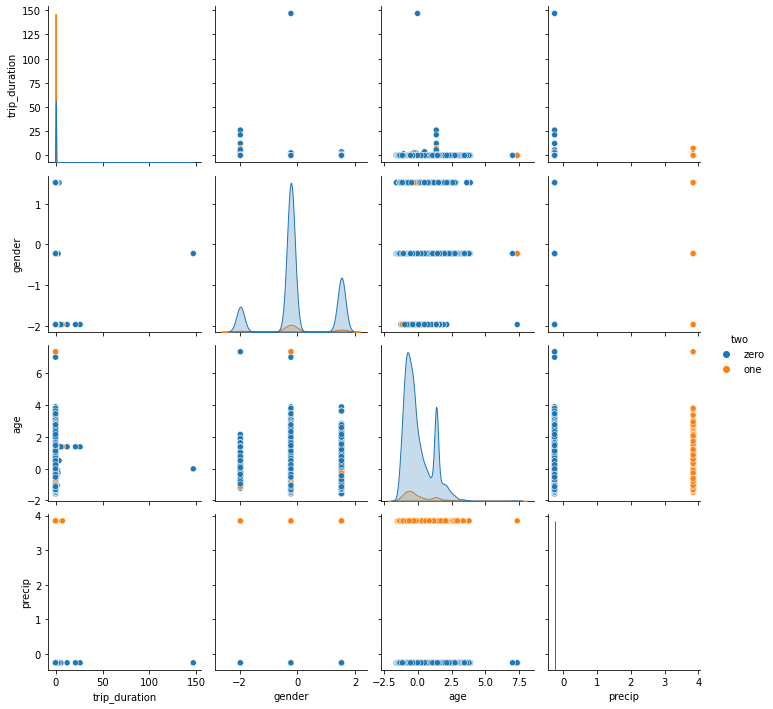

In [154]:
# Try two means
two_means = KMeans(n_clusters=2)
two_means.fit(x_scaled_sample)

two_means.predict(x_scaled_sample)
numbers = ["zero", "one", "two", "three"]

trip_scaled["two"] = two_means.predict(x_scaled_sample)
trip_scaled["two"] = trip_scaled["two"].apply(lambda x: numbers[x])
sns.pairplot(data=trip_scaled, hue="two")

In [ ]:
# # Try three means on sample data
# two_means = KMeans(n_clusters=5)
# two_means.fit(x_scaled_sample)

# two_means.predict(x_scaled_sample)
# numbers = ["zero", "one", "two", "three"]

# trip_scaled["two"] = two_means.predict(x_scaled_sample)
# trip_scaled["two"] = trip_scaled["two"].apply(lambda x: numbers[x])
# sns.pairplot(data=trip_scaled, hue="two")

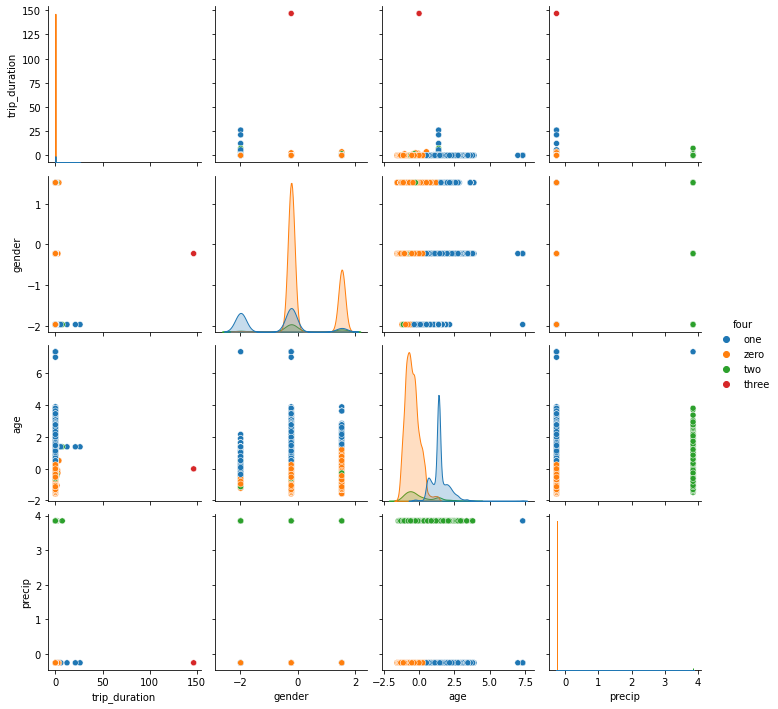

In [161]:
# Try 4 means on sample data
clusters = ['zero', 'one', 'two', 'three', 'four']

four_means = KMeans(n_clusters=4)
four_means.fit(x_scaled_sample)

Y = clustering_data[['user_type']]
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

trip_scaled['four'] = four_means.predict(x_scaled_sample)
trip_scaled['four'] = trip_scaled['four'].apply(lambda x: clusters[x])

# Plot
pairplot = sns.pairplot(data=trip_scaled, hue='four')

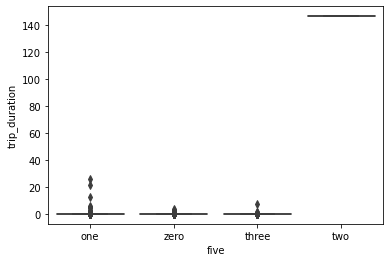

In [160]:
# Long distance usage
boxplot = sns.boxplot(x="five", y="trip_duration", data=trip_scaled)

In [157]:
# Try 5 means on full data
clusters = ['zero', 'one', 'two', 'three', 'four']

four_means = KMeans(n_clusters=4)
four_means.fit(x_scaled_sample)

Y = clustering_data[['user_type']]
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

trip_scaled_full = X_scaled_df
trip_scaled_full['five'] = four_means.predict(x_scaled_sample)
trip_scaled_full['five'] = trip_scaled_full['five'].apply(lambda x: clusters[x])

# Plot
pairplot = sns.pairplot(data=trip_scaled_full, hue='five')


ValueError: Length of values (22997) does not match length of index (2299685)

### Trip types